In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
import h5py

from dataset import dataset
from idataset import idataset
s = '/Volumes/LabDrive/'

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 1000
import matplotlib.pyplot as plt

# Load segmentation results

In [2]:
mov = idataset(date = '122418', exper_id = 's13', 
               frames_directory = s + 'Raw/', 
               times_directory = s + 'Timepoints/',
               masks_directory = s + 'Masks/',
               results_directory = s + 'Results/')

Loaded timelapse:
t = 130
z = 31
y = 589
x = 615


In [3]:
mov.crop_z(zmin = 12, zmax = 25)

Cropped timelapse:
t = 130
z = 14
y = 589
x = 615


In [4]:
mov.segment_frames(load_prev = True)

Successfully loaded segmentation from previous run.


In [5]:
mov.link_masks(searchRange_t = 30, threshold_t = 20)

Frame 129: 6 trajectories present.


# Load single cell results

In [6]:
lush = dataset(name='lush et al')

f = h5py.File(('geo-datasets/'
               'GSE123241.h5'),'r')
    
group = 'danRer10.Ens_84'

lush.raw_counts_from_sparse_matrix(
    
    cell_names = [i.decode('ascii') for i in f[group]['barcodes'][:]],
    gene_names = [i.decode('ascii') for i in f[group]['genes'][:]], 
    data = f[group]['data'], dtype = 'i4', indices = f[group]['indices'],
    indptr = f[group]['indptr'], shape = tuple(reversed(f[group]['shape'])) )

lush4i = pd.read_csv(('geo-datasets/'
                      'lush_fig4i.csv'),
                     index_col=0)

lush4i.sort_values('pseudotime', inplace=True)

In [7]:
lush.preprocess_raw_counts(library_size_cutoff=0)

In [8]:
lush.impute_from_normalized(genes='all_genes')

  Running MAGIC with `solver='exact'` on 14660-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [9]:
diff_traj = dataset(name='diff hair cell trajectory')

trajectory = lush4i.loc[lush4i['cluster'].isin([14,4,2,1])].index

diff_traj.raw_counts = lush.raw_counts.loc[trajectory]
diff_traj.normalized = lush.normalized.loc[trajectory]
diff_traj.imputed = lush.imputed.loc[trajectory]

In [10]:
diff_traj.pseudotimes = lush4i.loc[trajectory,'pseudotime']
diff_traj.clusters = lush4i.loc[trajectory,'cluster']

# Compile fluorescence results

In [18]:
log = pd.read_excel('seg_results/log.xlsx')
results = pd.DataFrame(columns = ['Timepoints (min)'])
results.set_index('Timepoints (min)', drop=True, inplace=True)

for file in os.listdir(s + 'Results/'):
    r = pd.read_csv(s + 'Results/' + file)
    
    idx = np.where((log['date']==int(file[:6])) & 
                   (log['exper_id']==file[7:-4]))[0][0]
    
    # align by cytokinesis and round timepoints to nearest 5 min
    r['Timepoints (min)'] -= round(log.loc[idx,'t_cytokinesis'] / 5) * 5
    r['Timepoints (min)'] = round(r['Timepoints (min)'] / 5) * 5
    
    r[file[:-4]] = r['Normalized (AU)']
    r.drop('Intensity/pixel (AU)', axis=1, inplace=True)
    r.drop('Normalized (AU)', axis=1, inplace=True)
    r.set_index('Timepoints (min)', drop=True, inplace=True)
    
    results = results.merge(r, 'outer', sort=True, 
                            left_index=True, right_index=True)
    
idxs = ((~results.isna()).sum(axis=1)>=1)
f = results[idxs].mean(axis=1)
f_25 = results[idxs].quantile(0.25, axis=1)
f_75 = results[idxs].quantile(0.75, axis=1)

# smooth 10m intervals
for i in f.index:
    w = [x for x in f.index if abs(x - i) <= 5]
    f[i] = f.loc[w].mean()
    f_25[i] = f_25.loc[w].mean()
    f_75[i] = f_75.loc[w].mean()
    
# times in hours
times = f.index/60

# trim the ends
f = f.iloc[6:-21]
f_25 = f_25.iloc[6:-21]
f_75 = f_75.iloc[6:-21]
times = times[6:-21]

# normalize to [0,1]
f_25 = (f_25-f.min())/(f.max()-f.min())
f_75 = (f_75-f.min())/(f.max()-f.min())
f = (f-f.min())/(f.max()-f.min())

# Generate figure: masks, fluorescence, transcripts

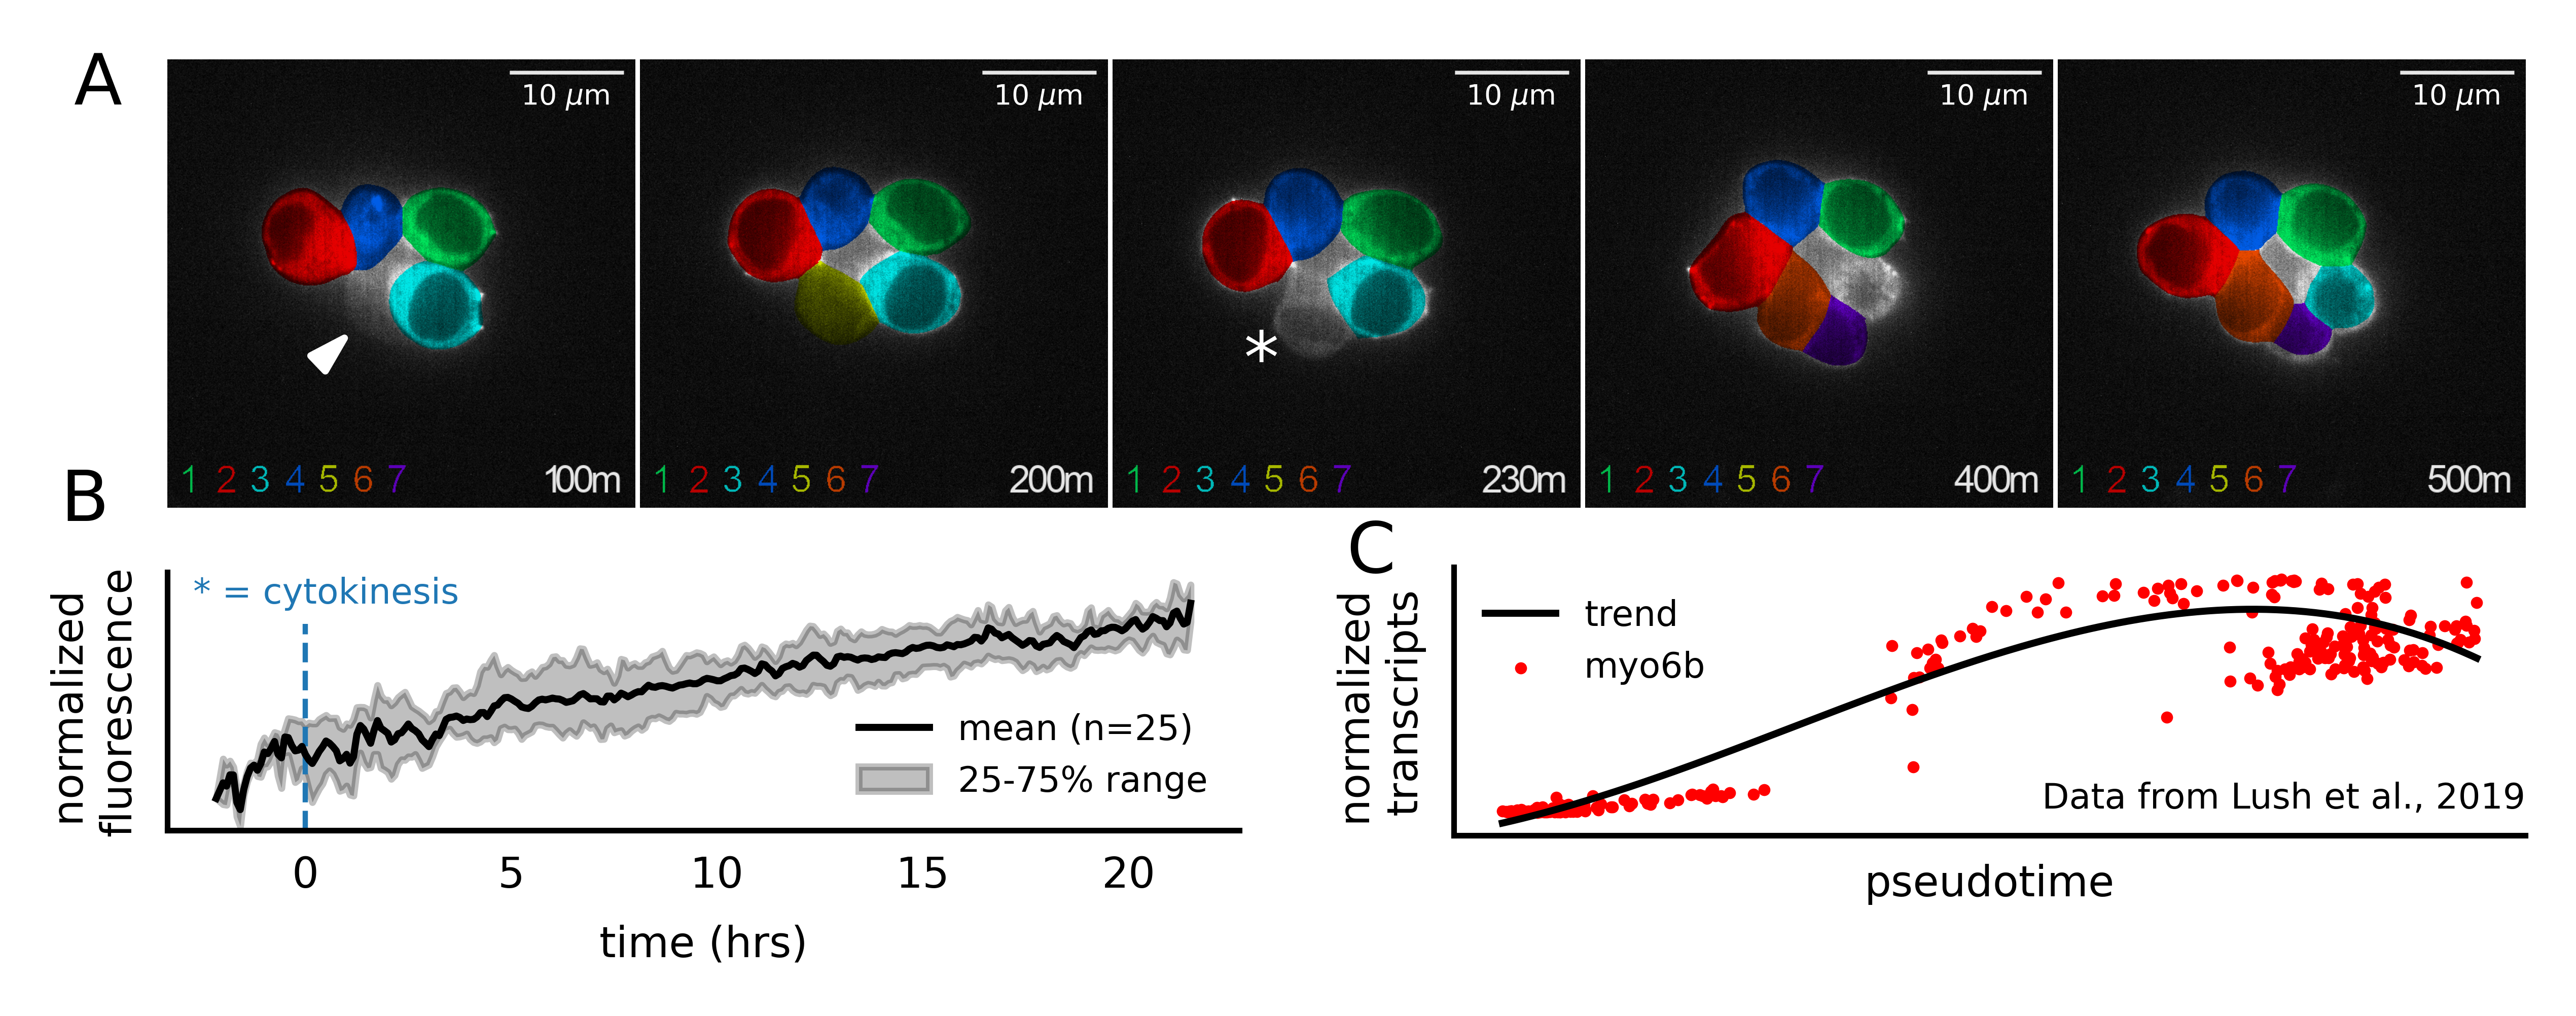

In [59]:
# plot microscopy images with masks
tidxs = [20,40,46,80,100]
fig, ax = plt.subplots(1, len(tidxs), 
            gridspec_kw={'wspace':0.01, 'hspace':0.01})
for i in range(len(tidxs)):
    img = mov.show_segmentation_at_depth(7)[tidxs[i]]
    img = np.array(img)
    
    # scale bar
    img[15:20, 450:600] = img.max(axis=None)
    
    ax[i].axes.imshow(img)
    ax[i].axis('off')
    
    # scale bar annotations
    ax[i].annotate(r'10 $\mu$m', (0.85,0.9), color='w', 
                   ha='center', size=4,
                   xycoords='axes fraction')
    
    if i == 0:
        # rising cell in first snapshot
        ax[i].annotate('', (0.4,0.4), (0.3,0.3),
                       xycoords='axes fraction',
                       arrowprops=dict(arrowstyle="wedge",
                                       color='w'))
        
        ax[i].annotate('A', (-0.2,0.9), color='k',
                       xycoords='axes fraction')
        
    if i == 2:
        # cytokinesis in third snapshot
        ax[i].annotate('*', (0.28,0.28), color='w',
                       xycoords='axes fraction')
        
        
    
#########################################################
# plot fluorescence results    
ax_ = fig.add_subplot(2,2,3)
ax_.plot(times, f, color='k', linewidth=1)
ax_.fill_between(times, f_75, f_25,
                 color='k', alpha=0.25)

# set aspect ratio
l,r = ax_.get_xlim()
b,t = ax_.get_ylim()
ax_.set_aspect(abs((r-l)/(b-t))*0.25)

# set axes labels
ax_.set_ylabel('normalized \nfluorescence')
ax_.set_xlabel('time (hrs)')
ax_.yaxis.label.set_size(6)
ax_.xaxis.label.set_size(6)

# fix axes bounding box
ax_.spines['top'].set_visible(False)
ax_.spines['right'].set_visible(False)

# modify ticks and labels
ax_.tick_params(left=False, labelleft=False)
ax_.tick_params(axis='x', length=0, labelsize=6)

# legend for mean / range
ax_.legend(['mean (n=25)','25-75% range'], 
           fontsize=5, loc=4, frameon=False);

# line / annotation at cytokinesis
plt.vlines(0, -0.1, 0.9, linestyle='dashed', 
           color='tab:blue', linewidth=0.75)
ax_.annotate('* = cytokinesis', (0.5,1), size=5, 
             color='tab:blue', ha='center')

ax_.set_ylim([-0.1,1.15])

ax_.annotate('B', (-0.1,1.2), color='k',
             xycoords='axes fraction')

#########################################################   
# plot sc expression: myo6b
ax_ = fig.add_subplot(2,2,4)
diff_traj.plot_gene(gene='ENSDARG00000042141', title='', 
                    smoothing=0.1, data='imputed', ax_=ax_)

# fix axes labels
ax_.set_ylabel('normalized \ntranscripts')
ax_.yaxis.label.set_size(6)
ax_.xaxis.label.set_size(6)

# fix axes bounding box
ax_.spines['top'].set_visible(False)
ax_.spines['right'].set_visible(False)

# turn off ticks and labels
ax_.tick_params(bottom=False, labelbottom=False, 
                left=False, labelleft=False)

# fix size of data points / line
ax_.get_children()[0].set_sizes([2])
ax_.get_children()[1].set_lw(1)

# legend for points / line
ax_.legend(['trend','myo6b'], 
           fontsize=5, loc=2, 
           frameon=False);

ax_.annotate('Data from Lush et al., 2019', (1,0.1), 
             size=5, color='k', ha='right',
             xycoords='axes fraction');

ax_.annotate('C', (-0.1,0.98), color='k',
             xycoords='axes fraction');

plt.savefig('grfp_figure.jpg')